In [123]:
import numpy as np
import matplotlib.pyplot as plt
import time

class Maze:
    def __init__(self):
        self.num_actions = 4
        self.initialize_maze()
        self.reset_state()
        
    def initialize_maze(self):
        self.maze = np.zeros((6, 9))
        self.maze[1:4, 2] = 1
        self.maze[4, 5] = 1
        self.maze[0:3, 7] = 1
        
    def reset_state(self):
        self.state = np.array([2, 0])
        return self.state
        
    def step(self, action):
        old_state = self.state.copy()
        if action == 0:
            self.state += np.array([-1, 0])
        elif action == 1:
            self.state += np.array([1, 0])
        elif action == 2:
            self.state += np.array([0, 1])
        else:
            self.state += np.array([0, -1])
            
        self.state = np.clip(self.state, np.array([0, 0]), np.array([5, 8]))
        if (self.state == np.array([0, 8])).all():
            reward = 1
            done = True
        else:
            if self.maze[self.state[0], self.state[1]] == 1:
                self.state = old_state
            reward = 0
            done = False
        return self.state, reward, done     
    

In [94]:
class DynaQ:
    def __init__(self, num_actions=4, num_states=(6, 9)):
        self.Q = np.zeros(num_states + (num_actions, ))
        self.model = np.zeros(num_states + (num_actions, 3))
        self.num_actions = num_actions
        
    def update_model(self, state, action, new_state, reward):
        self.model[state[0], state[1], action, ...] = np.concatenate([new_state, np.array([reward])])
        
    def sample_model(self, state, action):
        P = self.model[state[0], state[1], action, ...]
        new_state = P[0:2].astype("int32")
        reward = P[-1]
        return new_state, reward
    
    def update_Q(self, state, action, new_state, reward, alpha=0.1, gamma=0.95):
        self.Q[state[0], state[1], action] += alpha*(reward + gamma * np.amax(self.Q[new_state[0], new_state[1], ...]) - self.Q[state[0], state[1], action])
        
    def get_action(self, state, eps=0.1):
        if np.random.uniform(0, 1) <= eps:
            action = np.random.choice(self.num_actions)
        else:
            maximum = np.amax(self.Q[state[0], state[1], ...])
            action = np.random.choice(np.where(self.Q[state[0], state[1], ...] == maximum)[0])
        return action


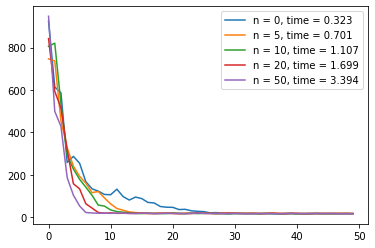

In [14]:
episodes = 50
averaging = 30
env = Maze()

for n in [0, 5, 10, 20, 50]:
    np.random.seed(42)
    STEPS = []
    TIME = []
    for _ in range(averaging):
        t1 = time.time()
        dq = DynaQ()
        steps = []
        for episode in range(episodes):
            env.reset_state()
            state_action_pairs = []
            done = False
            step = 0
            while not done:
                s = env.state.copy()
                a = dq.get_action(s)
                state_action_pairs.append((s, a))
                ns, r, done = env.step(a)
                step += 1
                dq.update_Q(s, a, ns, r)
                dq.update_model(s, a, ns, r)

                for k in range(n):
                    i = np.random.choice(len(state_action_pairs))
                    s, a = state_action_pairs[i]
                    ns, r = dq.sample_model(s, a)
                    dq.update_Q(s, a, ns, r)
            steps.append(step)
        STEPS.append(np.array(steps))
        t2 = time.time()
        TIME.append(t2 - t1)
    plt.plot(np.mean(STEPS, axis=0), label="n = %d, time = %0.3f" % (n, np.mean(TIME)))
plt.legend()


In [124]:
class NstepQ:
    def __init__(self, num_states = (6, 9), num_actions = 4, eps=0.1):
        self.Q = np.zeros(num_states + (num_actions, ))
        self.num_states = num_states
        self.num_actions = num_actions
        self.eps = eps
        
    def get_action(self, state):
        if np.random.uniform(0, 1) <= self.eps:
            action = np.random.choice(self.num_actions)
        else:
            maximum = np.amax(self.Q[state[0], state[1], ...])
            action = np.random.choice(np.where(self.Q[state[0], state[1], ...] == maximum)[0])
        return action
    
    def update_Q(self, state, action, ret, alpha=0.1):
        self.Q[state[0], state[1], action] += alpha*(ret - self.Q[state[0], state[1], action])
    
    def expected_return(self, state):
        p = np.zeros(self.num_actions)
        q = self.Q[state[0], state[1], ...]
        maximum = np.amax(q)
        count = len(np.where(q == maximum)[0])
        for action in np.where(q == maximum)[0]:
            p[action] += (1-self.eps) * 1./count
        for action in range(self.num_actions):
            p[action] += self.eps * 1./self.num_actions
        return np.dot(p, q)

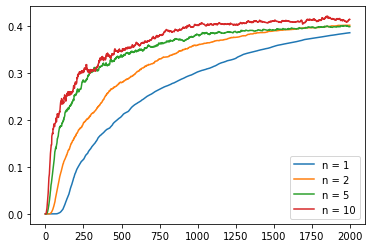

In [126]:
# Nstep Q(sigma) with sigma = 1 and on policy
episodes = 2000
averaging = 30
gamma = 0.95
env = Maze()

for n in [1, 2, 5, 10]:
    ER = []
    
    for _ in range(averaging):
        nstepq = NstepQ()
        expected_return = []
        for episode in range(episodes):
            states = [env.state.copy()]
            actions = [nstepq.get_action(states[-1])]
            rewards = [0]
            env.reset_state()
            T = np.inf
            done = False
            t = 0
            tau = t - n + 1
            while tau < T:
                if t < T:
                    s, r, done = env.step(actions[-1])
                    states.append(s.copy())
                    rewards.append(r)
                    if done:
                        T = t + 1
                    actions.append(nstepq.get_action(states[-1]))
                tau = t - n + 1
                if tau >= 0:
                    if t+1 < T:
                        G = nstepq.Q[states[t+1][0], states[t+1][1], actions[t+1]]
                    for k in range(min(t+1, T), tau, -1):
                        if k == T:
                            G = rewards[T]
                        else:
                            vbar = nstepq.expected_return(states[k])
                            G = rewards[k-1] + gamma*(G - nstepq.Q[states[k][0], states[k][1], actions[k]]) + gamma*vbar
                    nstepq.update_Q(states[tau], actions[tau], G)        
                t += 1
            expected_return.append(nstepq.expected_return([2, 0]))
        ER.append(expected_return)
    plt.plot(np.mean(ER, axis=0), label = "n = %d" % n)
plt.legend()